First, some housekeeping...

In [137]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import Descriptors
from rdkit.Chem import rdChemReactions as Reactions

# Define directories
SMRY_DIR = 'Rxn_Summs'
TYPE_DIR = 'Rxn_Type'
INV_DIR = 'Inventory'
PROP_DIR = 'Properties'

This Jupyter notebook is meant to serve as an example of how RouteScore is calculated in `RS_Base.py`.
All other RouteScore calculations are performed the same way.

First, import the various classes from `routescore.py`

In [138]:
from routescore import General, Reaction_Templates, Calculate
gen = General()
rxn = Reaction_Templates()
calc = Calculate()

Next, load a molecule from the targets list. Here, we will choose the molecule with the lowest RouteScore

We can skip lines 10-16 in `RS_Base.py` because they aren't required for calculating the RouteScore.

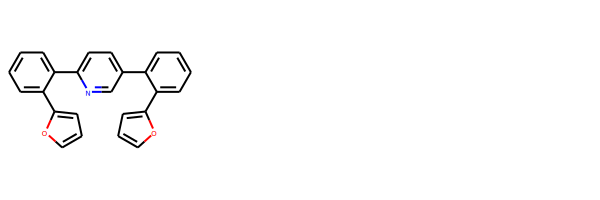

In [139]:
df = pd.read_pickle('./Targets/targets_Base.pkl')
target = df.loc[df.RouteScore.idxmin()]
gen.draw_mols([target.pentamer])

Step 1

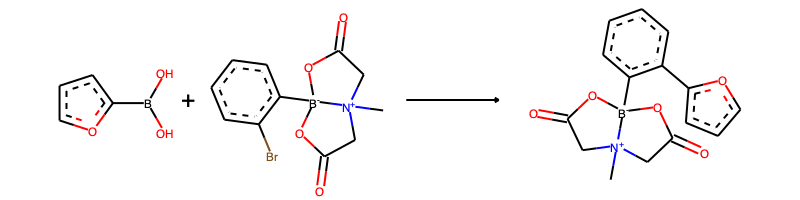

In [140]:
scale = 0.0001
rxn_smi = f'{target.a}.{target.b}>>{target.ab}'
rxn_obj = Reactions.ReactionFromSmarts(rxn_smi, useSmiles=True)
Draw.ReactionToImage(rxn_obj)

This next cell is the equivalent of `Reaction_Templates.wingSuzuki()`.

In [141]:
# List of reactant molecules and eq per reaction site
sm_list = [{'smiles': target.a, 'eq': 3},
           {'smiles': target.b, 'eq': 1}
           ]
# Number of reaction sites on the B molecule (1)
rxn_sites = rxn.stoichiometry(target.b, 'Suzuki')
print(f'Number of reaction sites on the molecule: {rxn_sites}')
# Total equivalents of A molecule
sm_list[0]['eq'] = rxn_sites * sm_list[0]['eq']
print(f"Updated equivalents of {target.a}: {sm_list[0]['eq']}")
# Unlike subsequent reactions, scale isn't normalized because for the limiting reagent
# We treat commercially available materials as being available in essentially unlimited quantities
wS_scale: float = scale
print(f'Scale of reaction: {wS_scale} mols')
wS_yield: float = 1
print('Assumed reaction yield: 100%')

Number of reaction sites on the molecule: 1
Updated equivalents of OB(O)c1ccco1: 3
Scale of reaction: 0.0001 mols
Assumed reaction yield: 100%


These next cells are the equivalent of `Calculate.StepScore()`.

In [142]:
multiplier = rxn_sites
product_smiles = target.ab

In [143]:
# Get information on starting materials from inventory
block_dicts = [calc.get_block_info(sm['smiles']) for sm in sm_list]
block_dicts

[{'Block_type': 'a',
  'Block_num': 5,
  'Name': 'furan-2-ylboronic acid',
  'SMILES': 'OB(O)c1ccco1',
  'g/mol': 111.893,
  'CAD': 69.0,
  'Quantity': 1.0,
  '$/mol': 7720.617,
  'Manual?': nan},
 {'Block_type': 'b',
  'Block_num': 1,
  'Name': '2-(2-bromophenyl)-6-methyl-1,3,6,2-dioxazaborocane-4,8-dione',
  'SMILES': 'C[N+]12CC(=O)O[B-]1(c1ccccc1Br)OC(=O)C2',
  'g/mol': 311.928,
  'CAD': 19.1,
  'Quantity': 1.0,
  '$/mol': 5957.8248,
  'Manual?': nan}]

In [144]:
# Get information on reagents for the reaction
reaction = gen.load_pkl(TYPE_DIR, 'Suzuki')
reaction


[{'$/mol': 137960, 'g/mol': 786.8, 'eq': 0.05, 'name': 'XPhos Pd G2'},
 {'$/mol': 196.98, 'g/mol': 212.27, 'eq': 2, 'name': 'K3PO4'}]

Calculate costs of synthesis

In [145]:
# Get reaction summary information
rxn_smry = gen.load_pkl(SMRY_DIR, 'Suzuki_summary')
print('The following numbers assumed that the robot is being used to its full capacity (48 parallel reactions).')
n_parr: int = rxn_smry['n_parr']
print(f'Number of reactions performed in parallel: {n_parr}')
t_H: float = rxn_smry['t_H'] / n_parr
print(f't_H: {t_H} hrs')
t_M: float = rxn_smry['t_M'] / n_parr
print(f't_M: {t_M} hrs')


The following numbers assumed that the robot is being used to its full capacity (48 parallel reactions).
Number of reactions performed in parallel: 48
t_H: 0.052083333333333336 hrs
t_M: 0.5833333333333334 hrs


In [146]:
# Time cost
cost_time: float = calc.TTC(t_H, t_M)
print(f'Time cost of reaction, TTC = {cost_time} hrs')

Time cost of reaction, TTC = 0.24804259351539967 hrs


In [147]:
# List of equivalents for each reactant
sm_eqs = [sm['eq'] for sm in sm_list]
block_costs = [sm['$/mol'] for sm in block_dicts]
# Monetary cost
cost_money, naive_chem_cost = calc.money(reaction,
                                         block_costs,
                                         sm_eqs,
                                         t_H,
                                         t_M,
                                         scale,
                                         multiplier)
print(f'Monetary cost of reaction: ${cost_money}')

Monetary cost of reaction: $16.392517746666666


In [148]:
block_MWs = [sm['g/mol'] for sm in block_dicts]
# Materials cost
cost_materials: float = calc.mass(reaction,
                                  block_MWs,
                                  sm_eqs,
                                  scale,
                                  multiplier)
print(f'Mass cost of reaction: {cost_materials}g')

Mass cost of reaction: 0.11114870000000002g


In [149]:
step_score_1 = cost_time * cost_money * cost_materials
print(f'StepScore for reaction 1 = {step_score_1} h*$*g')

StepScore for reaction 1 = 0.45193535092749476 h*$*g


Updating inventory.

In [150]:
MW: float = Descriptors.MolWt(Chem.MolFromSmiles(product_smiles))

# Add product information to inventory
product_dict: dict = {
                      'Block_type': '-',
                      'Block_num': 0,
                      'SMILES': product_smiles,
                      'Name': '-',
                      'g/mol': MW,
                      'Quantity': 0,
                      'CAD': 0,
                      '$/mol': 0,
                      'Manual?': ''
                      }
calc.update_inventory(product_smiles, product_dict)

calc.inv.to_csv('./Inventory/Inventory.csv', index=False)


Step 2

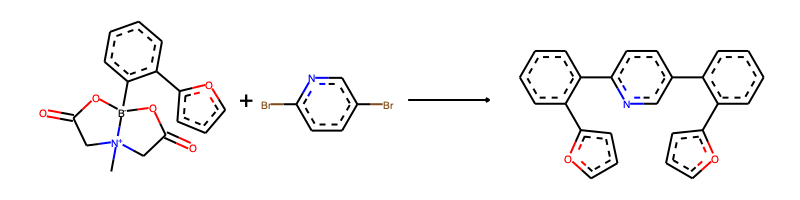

In [151]:
scale = wS_scale * wS_yield
rxn_smi = f'{target.ab}.{target.c}>>{target.pentamer}'
rxn_obj = Reactions.ReactionFromSmarts(rxn_smi, useSmiles=True)
Draw.ReactionToImage(rxn_obj)

This next cell is the equivalent of `Reaction_Templates.pentamerSuzuki()`.

In [152]:
# List of reactant molecules and eq per reaction site
sm_list = [{'smiles': target.ab, 'eq': 3},
           {'smiles': target.c, 'eq': 1}
           ]
# Number of reaction sites on the B molecule (1)
rxn_sites = rxn.stoichiometry(target.c, 'Suzuki')
print(f'Number of reaction sites on the molecule: {rxn_sites}')
# Total equivalents of A molecule
sm_list[0]['eq'] = rxn_sites * sm_list[0]['eq']
print(f"Updated equivalents of {target.ab}: {sm_list[0]['eq']}")
# Normalize scale for quantity of limiting reagent (AB)
pS_scale: float = scale / sm_list[0]['eq']
print(f'Scale of reaction: {pS_scale} mols')
pS_yield: float = 1
print('Assumed reaction yield: 100%')

Number of reaction sites on the molecule: 2
Updated equivalents of C[N+]12CC(=O)O[B-]1(c1ccccc1-c1ccco1)OC(=O)C2: 6
Scale of reaction: 1.6666666666666667e-05 mols
Assumed reaction yield: 100%


These next cells are the equivalent of `Calculate.StepScore()`.

In [153]:
multiplier = rxn_sites
product_smiles = target.pentamer

In [154]:
# Get information on starting materials from inventory
block_dicts = [calc.get_block_info(sm['smiles']) for sm in sm_list]
block_dicts

[{'Block_type': '-',
  'Block_num': 0,
  'Name': '-',
  'SMILES': 'C[N+]12CC(=O)O[B-]1(c1ccccc1-c1ccco1)OC(=O)C2',
  'g/mol': 299.091,
  'CAD': 0.0,
  'Quantity': 0.0,
  '$/mol': 0.0,
  'Manual?': nan},
 {'Block_type': 'c',
  'Block_num': 18,
  'Name': '2,5-dibromopyridine',
  'SMILES': 'Brc1ccc(Br)nc1',
  'g/mol': 236.894,
  'CAD': 110.0,
  'Quantity': 10.0,
  '$/mol': 2605.834,
  'Manual?': nan}]

In [155]:
# Get information on reagents for the reaction
reaction = gen.load_pkl(TYPE_DIR, 'Suzuki')
reaction

[{'$/mol': 137960, 'g/mol': 786.8, 'eq': 0.05, 'name': 'XPhos Pd G2'},
 {'$/mol': 196.98, 'g/mol': 212.27, 'eq': 2, 'name': 'K3PO4'}]

Calculate costs of synthesis

In [156]:
# Get reaction summary information
rxn_smry = gen.load_pkl(SMRY_DIR, 'Suzuki_summary')
print('The following numbers assumed that the robot is being used to its full capacity (48 parallel reactions).')
n_parr: int = rxn_smry['n_parr']
print(f'Number of reactions performed in parallel: {n_parr}')
t_H: float = rxn_smry['t_H'] / n_parr
print(f't_H: {t_H} hrs')
t_M: float = rxn_smry['t_M'] / n_parr
print(f't_M: {t_M} hrs')

The following numbers assumed that the robot is being used to its full capacity (48 parallel reactions).
Number of reactions performed in parallel: 48
t_H: 0.052083333333333336 hrs
t_M: 0.5833333333333334 hrs


In [157]:
# Time cost
cost_time: float = calc.TTC(t_H, t_M)
print(f'Time cost of reaction, TTC = {cost_time} hrs')

Time cost of reaction, TTC = 0.24804259351539967 hrs


In [158]:
# List of equivalents for each reactant
sm_eqs = [sm['eq'] for sm in sm_list]
block_costs = [sm['$/mol'] for sm in block_dicts]
# Monetary cost
cost_money, naive_chem_cost = calc.money(reaction,
                                         block_costs,
                                         sm_eqs,
                                         t_H,
                                         t_M,
                                         pS_scale,
                                         multiplier)
print(f'Monetary cost of reaction: ${cost_money}')

Monetary cost of reaction: $13.037850066666666


In [159]:
block_MWs = [sm['g/mol'] for sm in block_dicts]
# Materials cost
cost_materials: float = calc.mass(reaction,
                                  block_MWs,
                                  sm_eqs,
                                  pS_scale,
                                  multiplier)
print(f'Mass cost of reaction: {cost_materials}g')

Mass cost of reaction: 0.04932g


In [160]:
step_score_2 = cost_time * cost_money * cost_materials
print(f'StepScore for reaction 2 = {step_score_2} h*$*g')

StepScore for reaction 2 = 0.1594980265618537 h*$*g


Updating inventory.

In [161]:
MW: float = Descriptors.MolWt(Chem.MolFromSmiles(product_smiles))

# Add product information to inventory
product_dict: dict = {
                      'Block_type': '-',
                      'Block_num': 0,
                      'SMILES': product_smiles,
                      'Name': '-',
                      'g/mol': MW,
                      'Quantity': 0,
                      'CAD': 0,
                      '$/mol': 0,
                      'Manual?': ''
                      }
calc.update_inventory(product_smiles, product_dict)

calc.inv.to_csv('./Inventory/Inventory.csv', index=False)

In [162]:
final_scale = pS_scale * pS_yield
final_scale

1.6666666666666667e-05

Calculate RouteScore.

In [163]:
route_score = (step_score_1 + step_score_2) / final_scale
print(f'RouteScore = {route_score} h*$*g/(mol target)')

RouteScore = 36686.002649360904 h*$*g/(mol target)


Check that RouteScore calculated in the Jupyter notebook matches the stored RouteScore.

In [164]:
print(f'RouteScore calculated here: {route_score}')
here = round(route_score, 10)
print(f'Stored RouteScore: {target.RouteScore}')
stored = round(target.RouteScore, 10)
print(here == stored)
if here == stored:
    print('Success!')

RouteScore calculated here: 36686.002649360904
Stored RouteScore: 36686.00264936091
True
Success!
